# MS035 Preprocess
10/03/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GitHub/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS035'
subj_format = ['edf']
subj_site = ['MSSM']


#### Import Data

In [5]:
edf_files = glob(f'{neural_dir}/{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


In [6]:
mne_data

<RawEDF | MS035_SWB.edf, 276 x 3394048 (3314.5 s), ~6.98 GB, data loaded>

In [8]:
mne_data.ch_names

['LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'LplsF1',
 'LplsF2',
 'LplsF3',
 'LplsF4',
 'LplsF5',
 'LplsF6',
 'LplsF7',
 'LplsF8',
 'LplsF9',
 'LplsF10',
 'LplsF11',
 'LplsF12',
 'LplsF13',
 'LplsF14',
 'LplsF15',
 'LplsF16',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LmOlF10',
 'LmOlF11',
 'LmOlF12',
 'LCMAG1',
 'LCMAG2',
 'LCMAG3',
 'LCMAG4',
 'LCMAG5',
 'LCMAG6',
 'LCMAG7',
 'LCMAG8',
 'LCMAG9',
 'LCMAG10',
 'LCMAG11',
 'LCMAG12',
 'LCMAG13',
 'LCMAG14',
 'LpCsP1',
 'LpCsP2',
 'LpCsP3',
 'LpCsP4',
 'LpCsP5',
 'LpCsP6',
 'LpCsP7',
 'LpCsP8',
 'LpCsP9',
 'LpCsP10',
 'LpCsP11',
 'LpCsP12',
 'LpCsP13',
 'LpCsP14',
 'LHplT1',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LHplT10',
 'LHplT

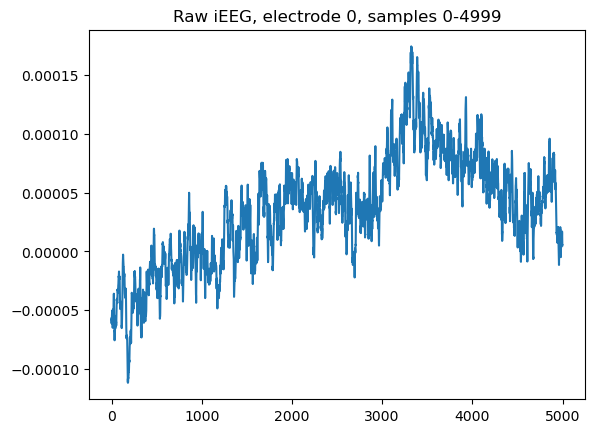

In [7]:
# Sanity check one channel data
plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Examine photodiode

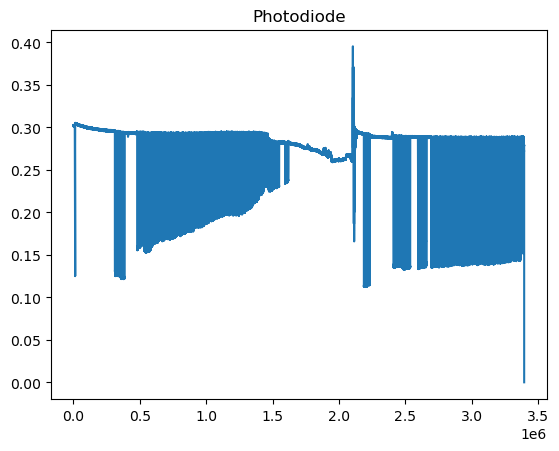

In [8]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

### Import Anat Recon Info - check all elecs are present in data + recon sheet


### Fix edf channel names

In [9]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

label BN246label          x          y          z      mni_x  \
0     LaCaS1    A32sg_L  -4.193839  40.722342  -1.249460  -3.409516   
1    LaCaS10   A9/46d_L -21.368608  57.508612  37.129623 -23.595365   
2    LaCaS11   A9/46d_L -23.365674  59.506978  41.127445 -25.838634   
3    LaCaS12    Unknown -25.362740  60.705997  45.525048 -28.069497   
4     LaCaS2    A32sg_L  -6.190905  42.321034   2.748361  -5.845285   
..       ...        ...        ...        ...        ...        ...   
167   RmOlF5     A11l_R  19.371542  47.117112  -6.846410  23.356883   
168   RmOlF6     A11l_R  23.765087  46.717439  -4.047935  28.298187   
169   RmOlF7  A12/47o_R  27.759220  46.717439  -1.249460  32.784291   
170   RmOlF8    A44op_R  31.753352  46.717439   1.948797  37.260470   
171   RmOlF9    Unknown  35.747484  46.317765   5.147054  41.673925   

         mni_y      mni_z       gm                                 NMM  \
0    28.122622  -4.643328     Gray  Left ACgG anterior cingulate gyrus   
1    46.014935  36.574161     Gray     Left SFG superior frontal gyrus   
2    48.159044  40.898034  Unknown     Left SFG superior frontal gyrus   
3    49.502020  45.723240  Unknown                             Unknown   
4    29.986278  -0.298868    White          Left Cerebral White Matter   
..         ...        ...      ...                                 ...   
167  34.915942 -10.712708    White     Right MOrG medial orbital gyrus   
168  34.880922  -7.718436     Gray  Right POrG posterior orbital gyrus   
169  35.177035  -4.651516    White         Right Cerebral White Matter   
170  35.337213  -1.005693     Gray         Right Cerebral White Matter   
171  35.356870   2.627926    White         Right Cerebral White Matter   

         Anat                 AnatMacro    BN246  \
0    Area s24                     L ACC     L CG   
1     Unknown    L Middle Frontal Gyrus    L MFG   
2     Unknown  L Superior Frontal Gyrus    L MFG   
3     Unknown                   Unknown  Unknown   
4     Unknown        L Olfactory cortex     L CG   
..        ...                       ...      ...   
167  Area Fo3       R IFG (p Orbitalis)    R OrG   
168  Area Fo3       R IFG (p Orbitalis)    R OrG   
169   Unknown       R IFG (p Orbitalis)    R OrG   
170   Unknown       R IFG (p Orbitalis)    R IFG   
171   Unknown    R IFG (p Triangularis)  Unknown   

                                  YBA_1 ManualExamination  Notes  
0                Left cingulate gyrus C               NaN    NaN  
1         Left middle frontal gyrus 3 A               NaN    NaN  
2         Left middle frontal gyrus 3 A               oob    NaN  
3                               Unknown               oob    NaN  
4                               Unknown               NaN    NaN  
..                                  ...               ...    ...  
167           Right frontal orbital 4 D               NaN    NaN  
168           Right frontal orbital 4 D               NaN    NaN  
169                             Unknown               NaN    NaN  
170  Right anterior pars triangularis B               NaN    NaN  
171                             Unknown               NaN    NaN  

[172 rows x 16 columns]

In [12]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LAglT10',
 'LAglT11',
 'LAglT12',
 'LCMAG1',
 'LCMAG2',
 'LCMAG3',
 'LCMAG4',
 'LCMAG5',
 'LCMAG6',
 'LCMAG7',
 'LCMAG8',
 'LCMAG9',
 'LCMAG10',
 'LCMAG11',
 'LCMAG12',
 'LCMAG13',
 'LCMAG14',
 'LHplT1',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LHplT10',
 'LHplT11',
 'LHplT12',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LmOlF10',
 'LmOlF11',
 'LmOlF12',
 'LpCsP1',
 'LpCsP2',
 'LpCsP3',
 'LpCsP4',
 'LpCsP5',
 'LpCsP6',
 'LpCsP7',
 'LpCsP8',
 'LpCsP9',
 'LpCsP10',
 'LpCsP11',
 'LpCsP12',
 'LpCsP13',
 'LpCsP14',
 'LpISF1',
 'LpISF2',
 'LpISF3'

In [10]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [11]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [12]:
new_name_dict


{'LmOIF1': 'lmolf1',
 'LmOIF2': 'lmolf2',
 'LmOIF3': 'lmolf3',
 'LmOIF4': 'lmolf4',
 'LmOIF5': 'lmolf5',
 'LmOIF6': 'lmolf6',
 'LmOIF7': 'lmolf7',
 'LmOIF8': 'lmolf8',
 'LmOIF9': 'lmolf9',
 'LmOIF10': 'lmolf10',
 'LmOIF11': 'lmolf11',
 'LmOIF12': 'lmolf12',
 'RmOIFM1': 'rmolf1',
 'RmOIFM2': 'rmolf2',
 'RmOIFM3': 'rmolf3',
 'RmOIFM4': 'rmolf4',
 'RmOIFM5': 'rmolf5',
 'RmOIFM6': 'rmolf6',
 'RmOIFM7': 'rmolf7',
 'RmOIFM8': 'rmolf8',
 'RmOIFM9': 'rmolf9',
 'RmOIFM10': 'rmolf10',
 'RmOIFM11': 'rmolf11',
 'RmOIFM12': 'rmolf12',
 'LAlmM1': 'laimm1',
 'LAlmM2': 'laimm2',
 'LAlmM3': 'laimm3',
 'LAlmM4': 'laimm4',
 'LAlmM5': 'laimm5',
 'LAlmM6': 'laimm6',
 'LAlmM7': 'laimm7',
 'LAlmM8': 'laimm8',
 'LAlmM9': 'laimm9',
 'LAlmM10': 'laimm10',
 'LAlmM11': 'laimm11',
 'LAlmM12': 'laimm12',
 'LAlmM13': 'laimm13',
 'LAlmM14': 'laimm14',
 'LAlmM15': 'laimm15',
 'LAlmM16': 'laimm16',
 'RalmS1': 'raims1',
 'RalmS2': 'raims2',
 'RalmS3': 'raims3',
 'RalmS4': 'raims4',
 'RalmS5': 'raims5',
 'RalmS6': 'raims

In [13]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS035_SWB.edf, 276 x 3394048 (3314.5 s), ~6.98 GB, data loaded>

In [14]:
unmatched_seeg #make sure there are no unmatched names


[]

In [15]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c57', 'c58', 'c59', 'c60', 'c61', 'c62', 'c63', 'c64', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'dc', 'chest1', 'chest2', 'abs1', 'abs2', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c242', 'c243', 'c244', 'c245', 'c246', 'c247', 'c248', 'c249', 'c250', 'c251', 'c252', 'c253', 'c254', 'c255', 'c256', 'dc1', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', 'pleth']


In [16]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 86 left & 86 right sEEG electrodes
We have a total of 172 sEEG electrodes


In [17]:
list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1'])) #list of non seeg/photodiode channels

['c244',
 'c214',
 'c233',
 'c255',
 'c216',
 'c63',
 'c58',
 'c235',
 'dc5',
 't4',
 'c253',
 'c241',
 'c222',
 'c217',
 'c211',
 'dc2',
 'c251',
 'c208',
 't6',
 'f3',
 'c210',
 'c229',
 'f8',
 'c247',
 'c246',
 'c64',
 'c227',
 'abs1',
 'abs2',
 'osat',
 'dc7',
 'o1',
 'c240',
 'dc6',
 'dc10',
 'c249',
 'c225',
 'p4',
 'c252',
 'c243',
 'c59',
 'c215',
 'c239',
 'c245',
 'c57',
 'c242',
 'ekg2',
 'dc16',
 'cz',
 'fp1',
 'dc9',
 'pr',
 'f4',
 'c232',
 'c237',
 'fz',
 'dc',
 'c248',
 'c256',
 'c209',
 'c231',
 'c250',
 'f7',
 'c224',
 'c207',
 'dc13',
 'c234',
 'chest2',
 'c238',
 'c61',
 'c213',
 't5',
 'c230',
 'c220',
 't3',
 'dc14',
 'c3',
 'c219',
 'dc15',
 'c62',
 'dc12',
 'dc11',
 'c254',
 'trig',
 'c228',
 'c4',
 'dc8',
 'c221',
 'c218',
 'pleth',
 'c236',
 'pz',
 'chest1',
 'p3',
 'fp2',
 'ekg1',
 'c226',
 'dc4',
 'dc3',
 'c223',
 'c60',
 'c212',
 'o2']

In [18]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1']))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs + 1 (photodiode)

<RawEDF | MS035_SWB.edf, 173 x 3394048 (3314.5 s), ~4.37 GB, data loaded>

In [19]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
trig_mapping_dict = {'dc1':'stim'} 
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawEDF | MS035_SWB.edf, 173 x 3394048 (3314.5 s), ~4.37 GB, data loaded>

In [20]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS035_SWB.edf, 173 x 3394048 (3314.5 s), ~4.37 GB, data loaded>

### Notch filter line noise

In [21]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 172 out of 172 | elapsed:   12.6s finished


<RawEDF | MS035_SWB.edf, 173 x 3394048 (3314.5 s), ~4.37 GB, data loaded>

### Resampling data 

In [22]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 173 out of 173 | elapsed:   13.9s finished


<RawEDF | MS035_SWB.edf, 173 x 1657250 (3314.5 s), ~2.14 GB, data loaded>

### Save out photodiode data
Note: this is after filtering out line noise and resampling

In [23]:
mne_data.save(f'{neural_dir}/{subj_id}/photodiode.fif', picks='dc1', overwrite=True)

In [24]:
mne_data.drop_channels('dc1')

<RawEDF | MS035_SWB.edf, 172 x 1657250 (3314.5 s), ~2.12 GB, data loaded>

### Bad Channel Removal (automated + manual inspection)

In [74]:
### I skip this step because it doesn't work for me 

# bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)
# bads
# mne_data.info['bads'] = bads
#9/26/23 - too strict, manually overriding 

In [25]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [26]:
probe_names

array(['lacas', 'lagit', 'laims', 'lhplt', 'lloif', 'lmoif', 'lpips',
       'lsif', 'racas', 'ragit', 'raims', 'rhplt', 'rmoif'], dtype='<U5')

In [27]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [28]:
probe_ch_counts

{'lacas': 12,
 'lagit': 10,
 'laims': 14,
 'lhplt': 12,
 'lloif': 10,
 'lmoif': 14,
 'lpips': 14,
 'lsif': 8,
 'racas': 14,
 'ragit': 12,
 'raims': 14,
 'rhplt': 12,
 'rmoif': 12}

<IPython.core.display.Javascript object>


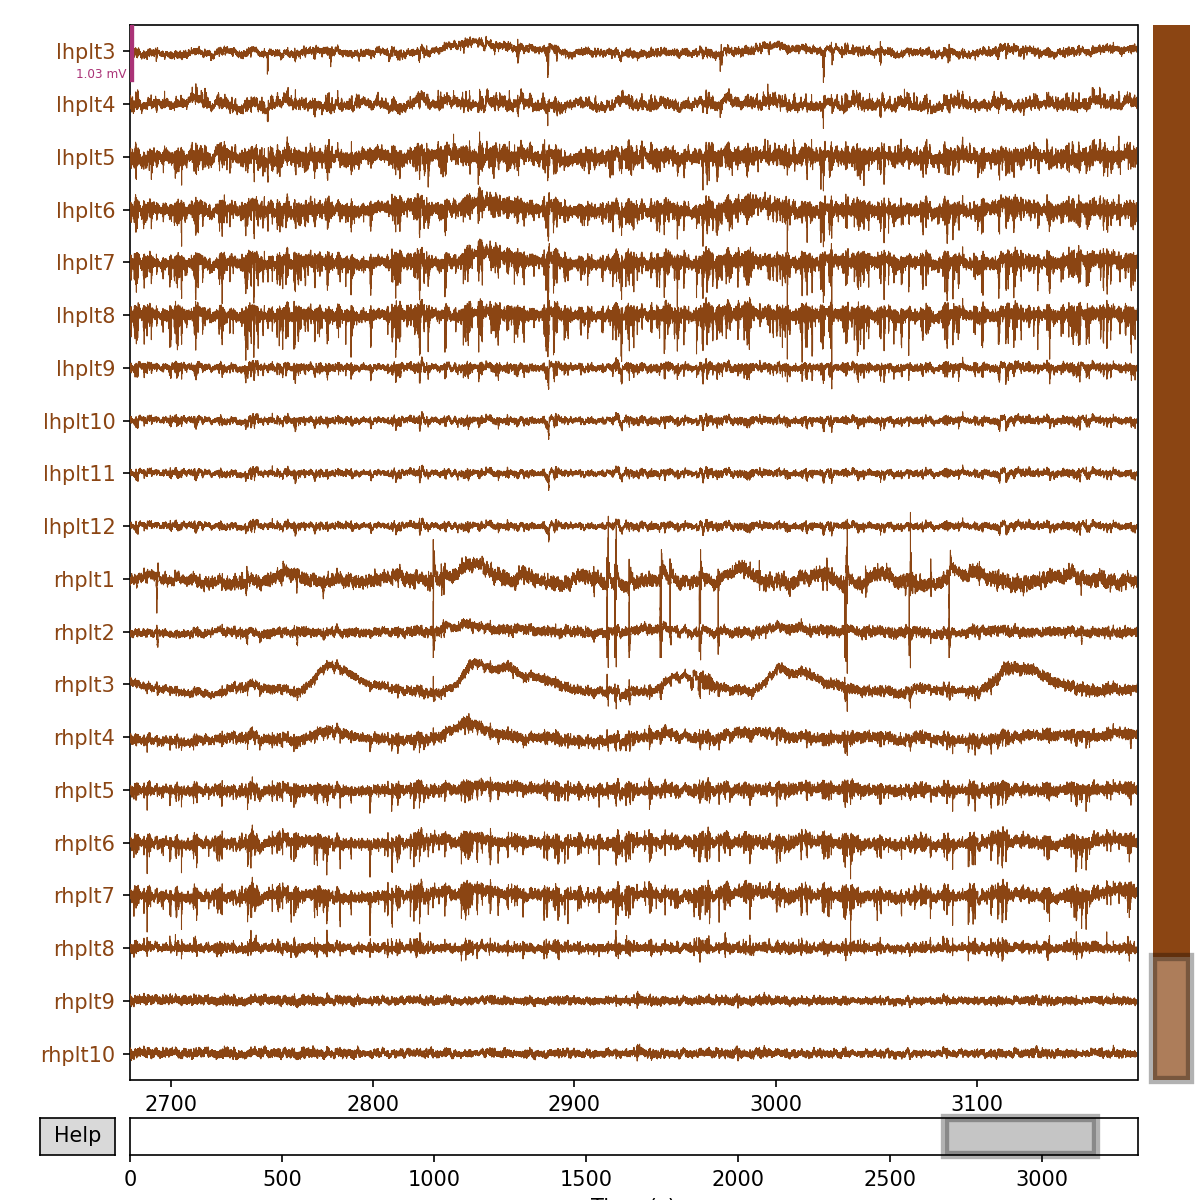

<IPython.core.display.Javascript object>


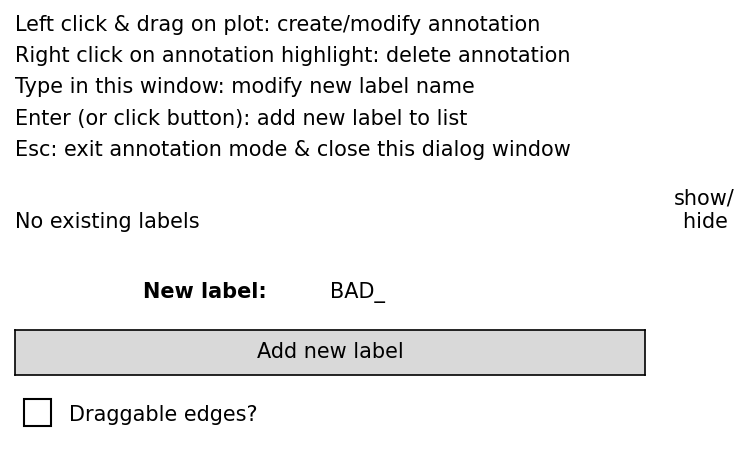

In [29]:
%matplotlib notebook 
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=500, n_channels=20, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

<IPython.core.display.Javascript object>


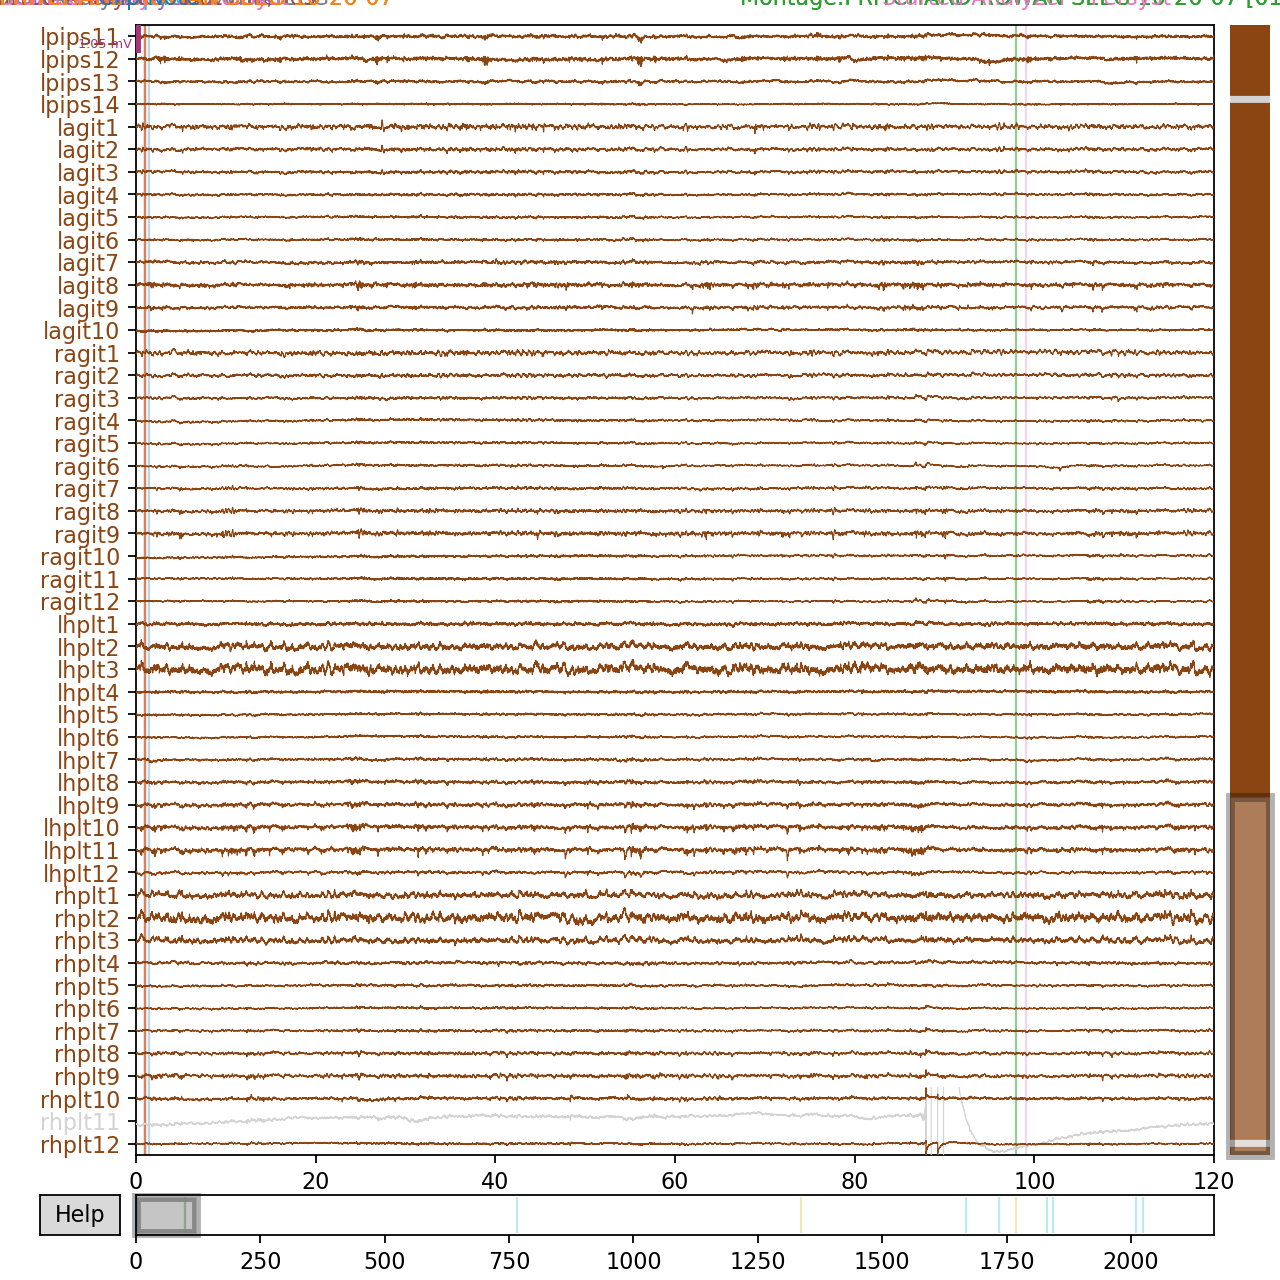

<IPython.core.display.Javascript object>


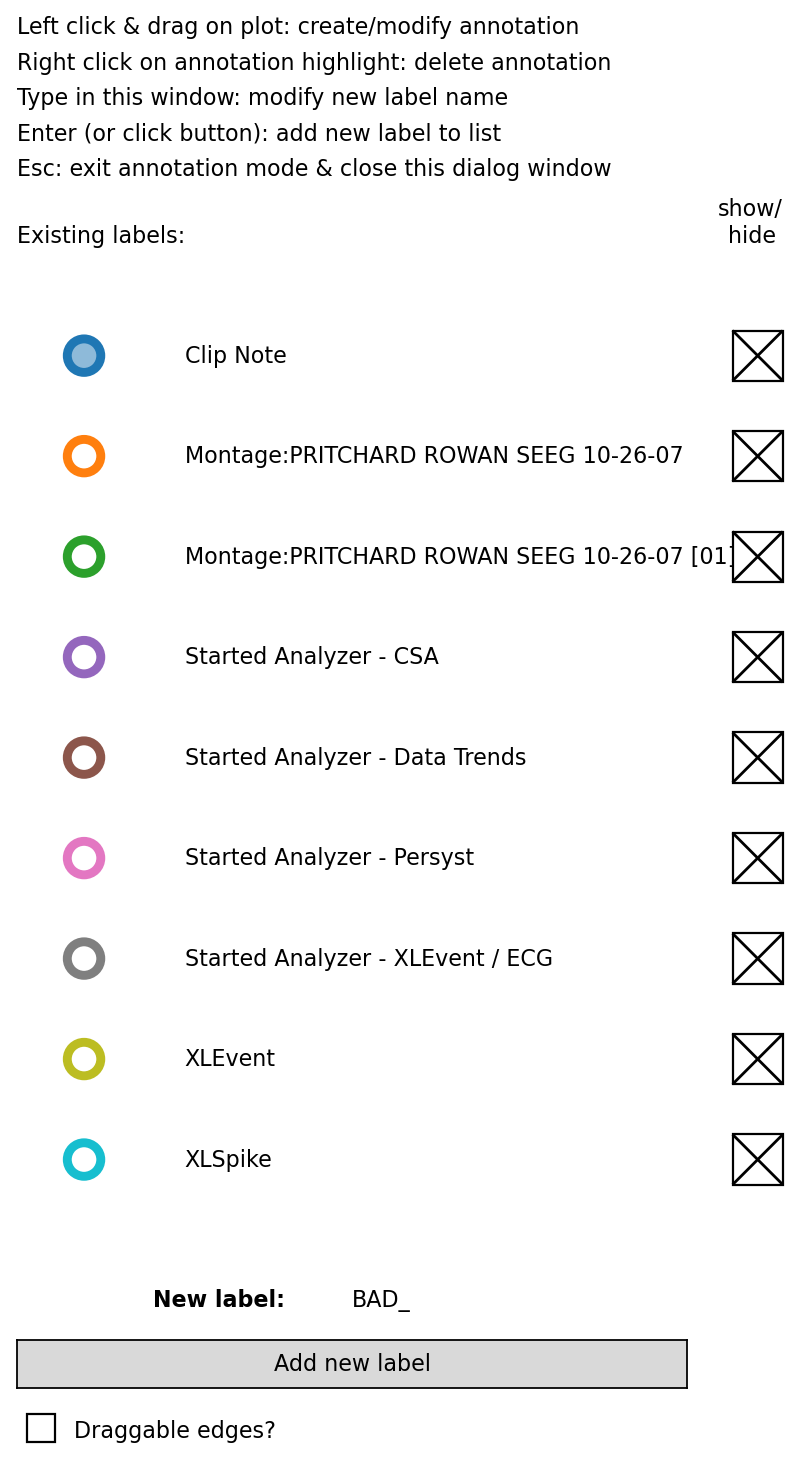

In [34]:
%matplotlib notebook
fig = mne_data.plot(start=0, duration=120, n_channels=50, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [35]:
mne_data.info['bads'] = ['lmoif1', 'rhplt11']

In [107]:
#if plot is being buggy - manually set bads

#ms002_bad_ch = ['rhplt11', 'lmoif1']
#mne_data.info['bads'] = ms002_bad_ch 

In [36]:
mne_data.info['bads']

['lmoif1', 'rhplt11']

In [36]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 2 items (lmoif1, rhplt11)
 ch_names: lloif1, lloif2, lloif3, lloif4, lloif5, lloif6, lloif7, lloif8, ...
 chs: 158 sEEG
 custom_ref_applied: False
 dig: 158 items (158 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 15:59:08 UTC
 nchan: 158
 projs: []
 sfreq: 500.0 Hz
>

## Save raw LFP data
Notch filtered and resampled with bad elecs indicated

In [30]:
#define oob elecs as bad before saving out lfp file 
oob_elec = [elec_locs['label'].iloc[ind].lower() for ind, data in elec_locs['ManualExamination'].str.lower().items() if data=='oob']
oob_elec

['lacas10',
 'lacas11',
 'lacas12',
 'laglt11',
 'laglt12',
 'lcmag14',
 'lhplt10',
 'lhplt11',
 'lhplt12',
 'lmcms4',
 'lmcms10',
 'lmolf10',
 'lmolf12',
 'lpcsp13',
 'lpcsp14',
 'lpisf10',
 'lpisf15',
 'lpisf16',
 'lptpt10']

In [42]:
bad_ch= ['rhplt11', 'lmoif1'] #or =mne_data.info['bads']
bad_ch = bad_ch + oob_elec
mne_data.info['bads'] = bad_ch
mne_data.info['bads']

['rhplt11',
 'lmoif1',
 'lacas11',
 'lacas12',
 'lagit10',
 'lloif5',
 'lmoif14',
 'lpips14',
 'racas10',
 'racas11',
 'racas14',
 'ragit11',
 'ragit12',
 'raims5',
 'rhplt12',
 'rmoif11',
 'rmoif12']

In [31]:
mne_data.save(f'{neural_dir}/{subj_id}/raw_ieeg.fif',overwrite=True)

# Rereference data - Both WM ref and Bipolar ref!

In [7]:
# mne_data = mne.io.read_raw_fif(f'{neural_dir}/{subj_id}/raw_ieeg.fif')

In [9]:
elec_locs.ManualExamination

0      NaN
1      NaN
2      OOB
3      OOB
4      NaN
      ... 
153     WM
154    NaN
155    NaN
156    NaN
157    NaN
Name: ManualExamination, Length: 158, dtype: object

### WM REF

In [32]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [33]:
mne_data_wm_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [ ]:
mne_data_reref.drop_channels([x for x in mne_data_reref.ch_names if '-' not in x])

In [45]:
mne_data_wm_reref.ch_names

['lloif5',
 'lloif6',
 'lmoif4',
 'lmoif7',
 'lmoif14',
 'rmoif5',
 'rmoif11',
 'rmoif12',
 'lacas9',
 'lacas11',
 'lacas12',
 'racas4',
 'racas5',
 'racas10',
 'racas11',
 'racas14',
 'laims7',
 'laims8',
 'laims9',
 'raims5',
 'raims7',
 'raims9',
 'raims10',
 'lsif3',
 'lsif5',
 'lpips5',
 'lpips7',
 'lpips9',
 'lpips14',
 'lagit6',
 'lagit8',
 'lagit10',
 'ragit5',
 'ragit11',
 'ragit12',
 'lhplt5',
 'lhplt6',
 'rhplt4',
 'rhplt5',
 'rhplt7',
 'rhplt12',
 'lacas1-lmoif3',
 'lacas10-laims14',
 'lacas2-lmoif5',
 'lacas3-lmoif5',
 'lacas4-lmoif5',
 'lacas5-lmoif6',
 'lacas6-laims10',
 'lacas7-laims10',
 'lacas8-laims14',
 'lagit1-lagit5',
 'lagit2-lagit5',
 'lagit3-lagit5',
 'lagit4-lagit5',
 'lagit7-lagit5',
 'lagit9-lagit5',
 'laims1-lloif4',
 'laims11-laims14',
 'laims12-laims14',
 'laims13-lpips12',
 'laims2-lloif4',
 'laims3-lloif4',
 'laims4-lloif4',
 'laims5-lsif1',
 'laims6-lsif1',
 'lhplt1-lagit5',
 'lhplt10-lhplt8',
 'lhplt11-lhplt8',
 'lhplt12-lhplt8',
 'lhplt2-lagit5',
 'l

<IPython.core.display.Javascript object>


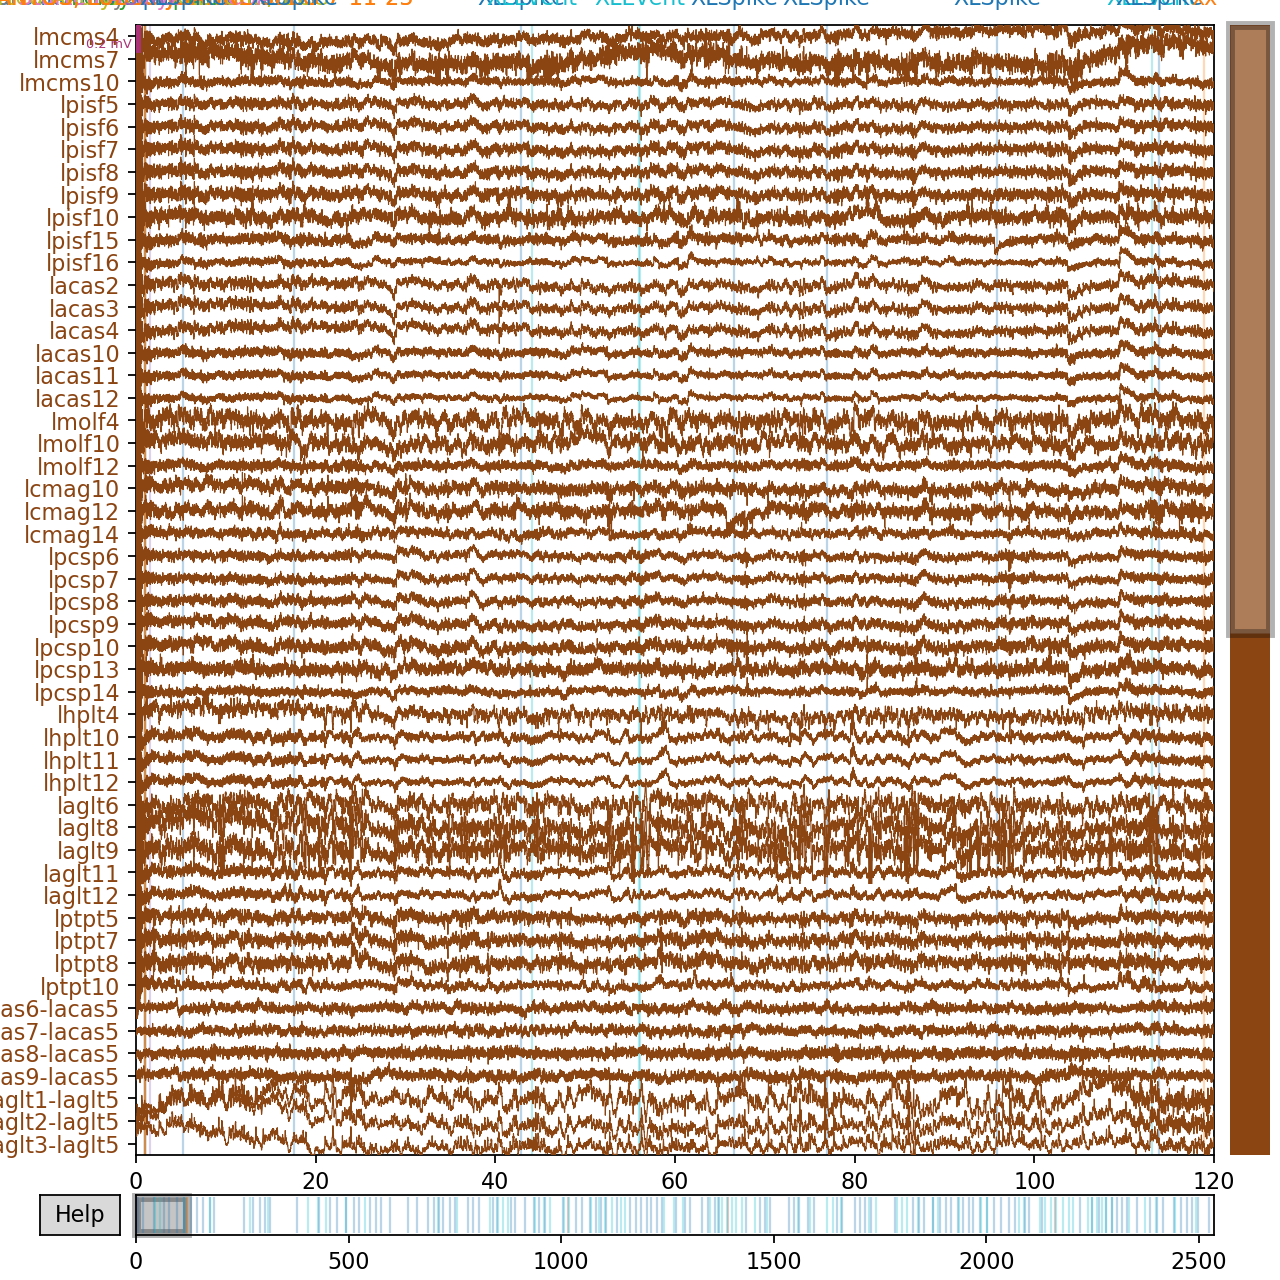

<IPython.core.display.Javascript object>


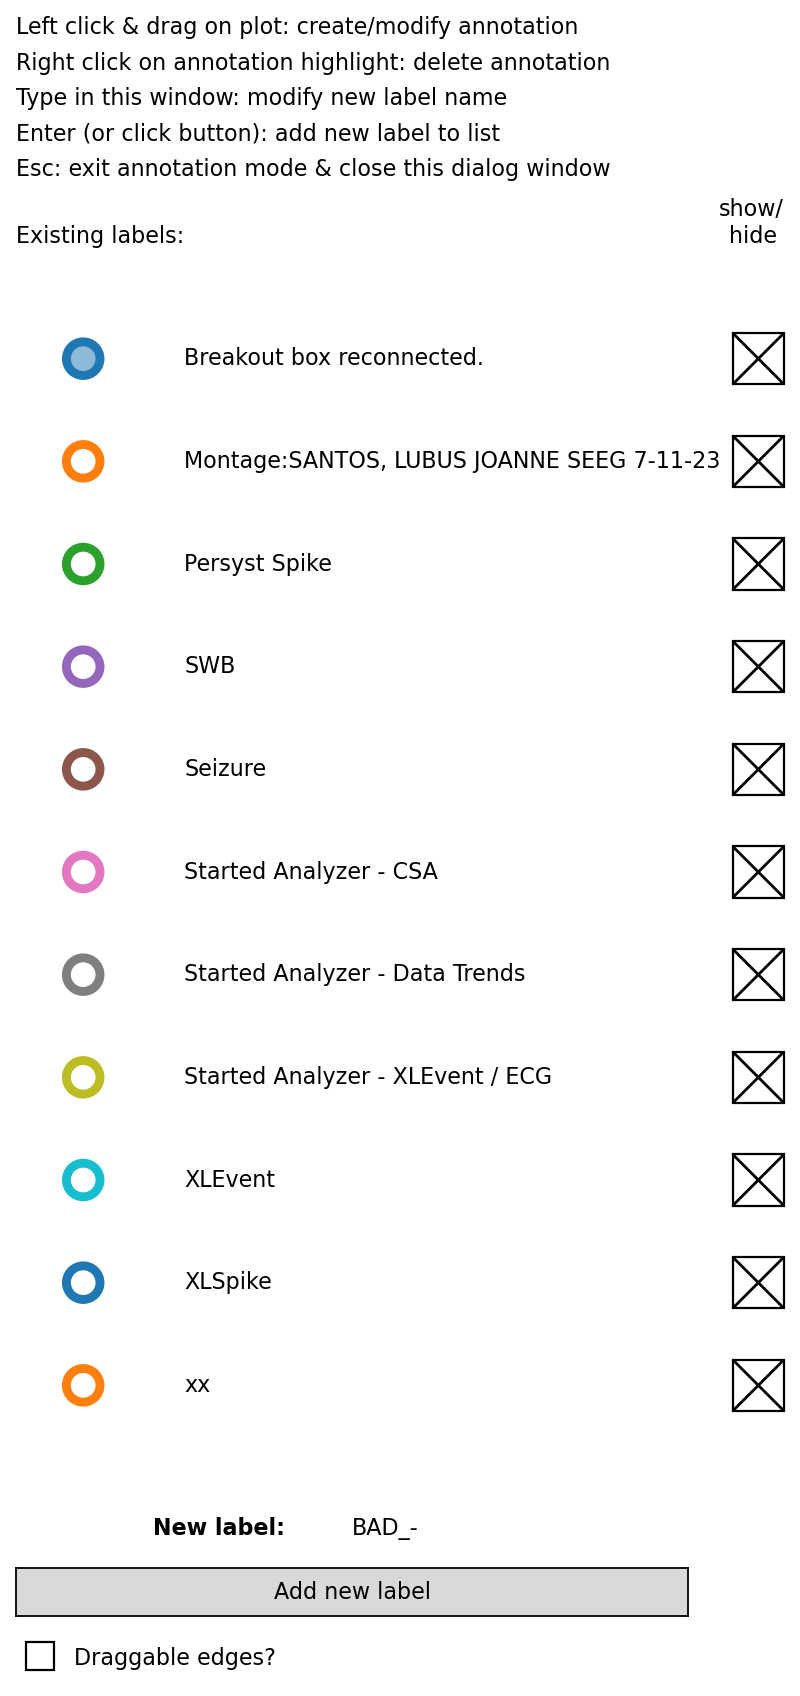

In [36]:
%matplotlib notebook
%matplotlib notebook

fig = mne_data_wm_reref.plot(start=0, duration=120, n_channels=50)
fig.fake_keypress('a')

###  BIPOLAR REF

In [37]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.bipolar_ref(elec_path=anat_file, 
                                       bad_channels=mne_data.info['bads'], 
                                       unmatched_seeg=unmatched_seeg,
                                       site='MSSM')

In [38]:
mne_data_bp_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [39]:
mne_data_bp_reref

<RawEDF | MS033_SWB.edf, 103 x 1267594 (2535.2 s), ~996.3 MB, data loaded>

<IPython.core.display.Javascript object>


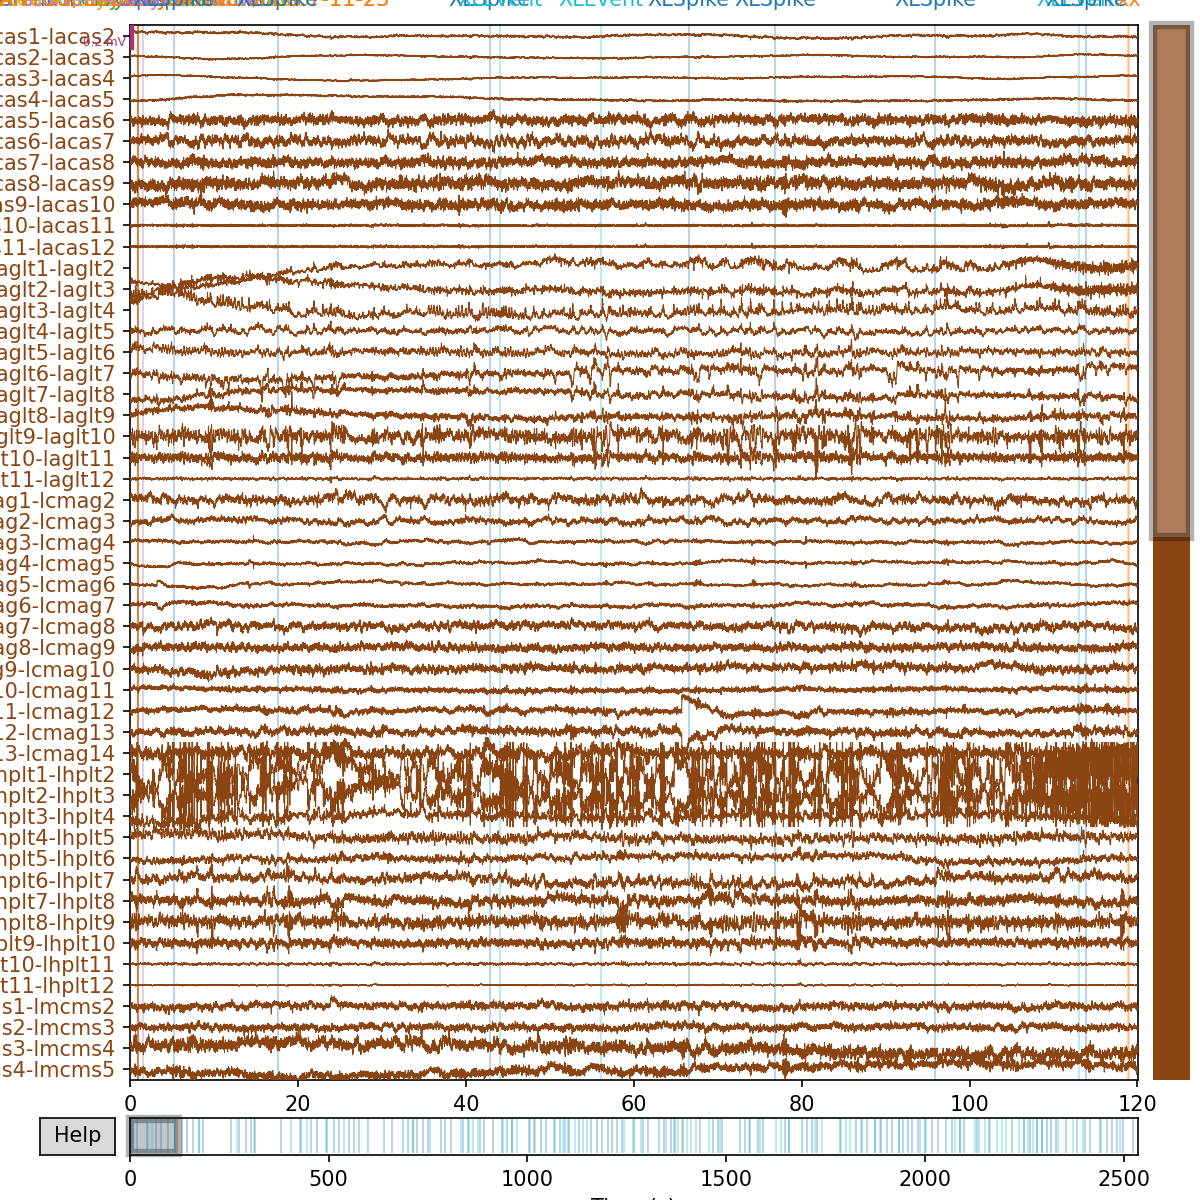

<IPython.core.display.Javascript object>


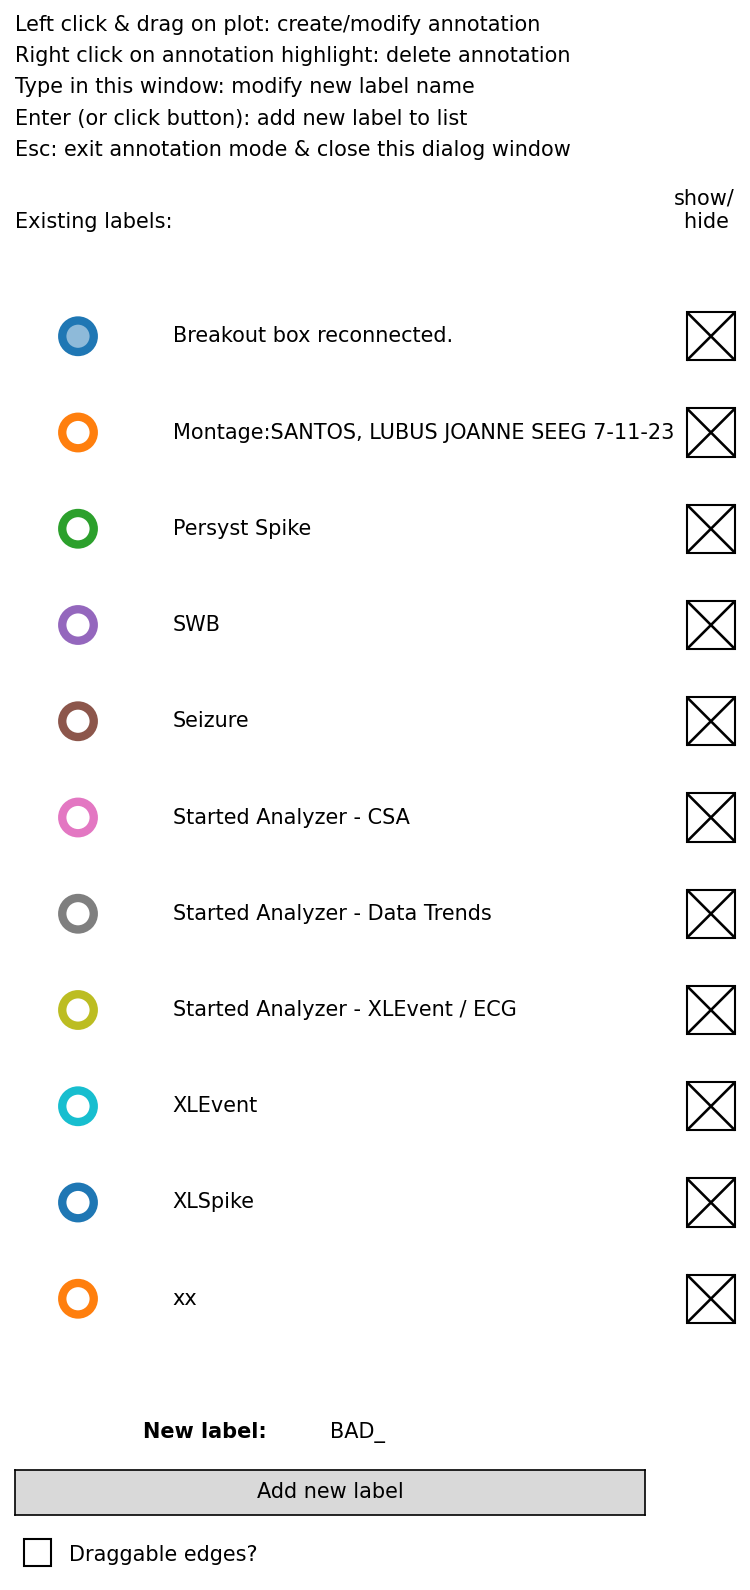

In [41]:
%matplotlib notebook
%matplotlib notebook

fig = mne_data_bp_reref.plot(start=0, duration=120, n_channels=50)
fig.fake_keypress('a')

## Save reref data

In [99]:
mne_data_wm_reref.save(f'{neural_dir}/MS002/wm_ref_ieeg.fif',overwrite=True)

In [100]:
mne_data_bp_reref.save(f'{neural_dir}/MS002/bp_ref_ieeg.fif',overwrite=True)